# Angular Distribution Plot Maker

In [1]:
import sys
sys.path.append("../SimulationCode")
import astropy.units as u
import astropy.constants as c
import BaryakhtarFunctions as func
import numpy as np
import matplotlib.pyplot as plt
import superrad as sr
import superrad.harmonics as har

## Annihilation Signal
### 211 Level

For the 211 level, we have that:

$$\frac{dP}{d\Omega}=\frac{9 \pi G\hbar^2}{2^{26} c} \frac{N_{211}^2\alpha^{18}}{r_g^4}\left(35 + 28\cos2\theta +\cos 4\theta\right)$$

In [2]:
def ang_211_power(N_211,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = 9*func.G*func.hbar**2/(2**26*func.c)
    scale = N_211**2*alpha**18/r_g**4
    angular_dependence = (35+28*np.cos(2*theta)+np.cos(4*theta))
    return const*scale*angular_dependence

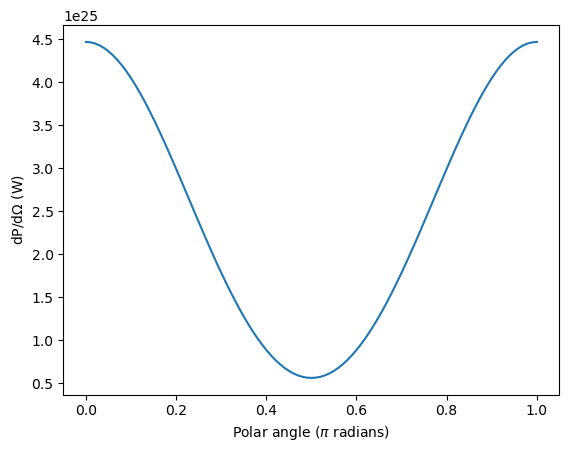

In [3]:
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi

# Plot power
plt.plot(theta_in_pi,ang_211_power(1e76,0.1,theta,10))
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("dP/d$\Omega$ (W)")
plt.show()

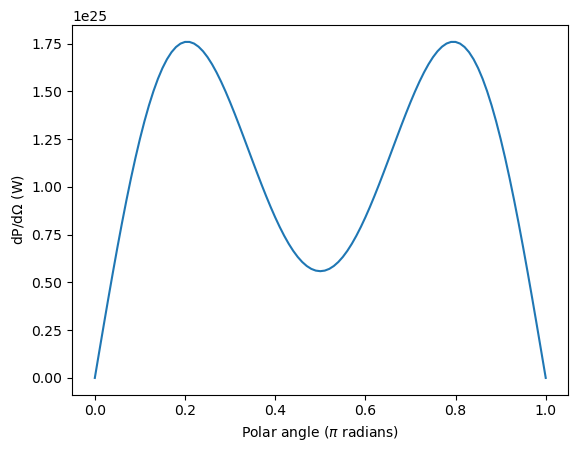

In [4]:
# Plot power
plt.plot(theta_in_pi,np.sin(theta)*ang_211_power(1e76,0.1,theta,10))
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("dP/d$\Omega$ (W)")
plt.show()

In [5]:
# Compute max vs. integral
ang_211_template = ang_211_power(1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_211_template)
max_v_auc_211 = max(ang_211_template)/auc

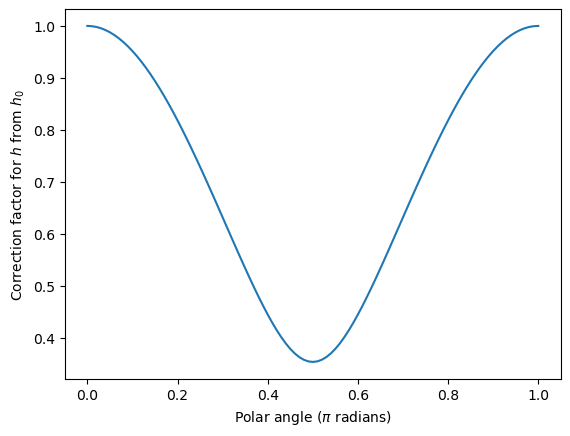

In [6]:
# Compute h factor function
h_function_211 = ((ang_211_template/auc)/max_v_auc_211)**0.5

plt.plot(theta_in_pi,h_function_211)
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("Correction factor for $h$ from $h_0$")
plt.show()

#### An Aside: Correction factor of $h$ from Angular-Averaged $h_0$

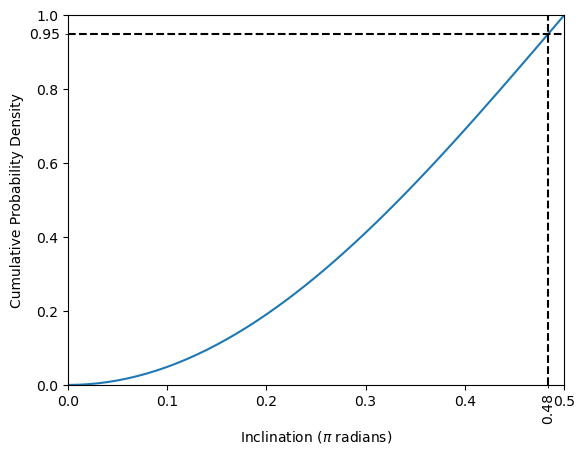

5% Percentile h-factor is: 0.3561962678776969


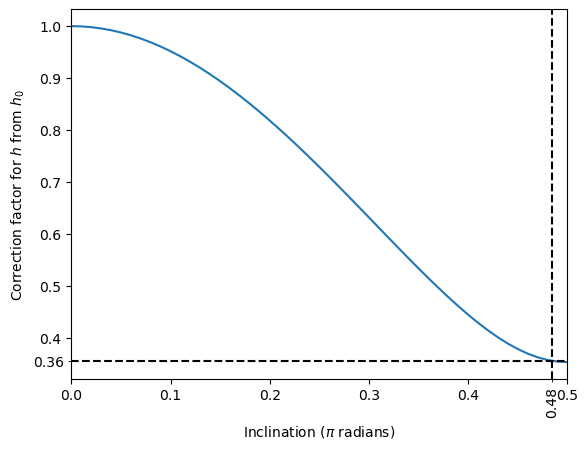

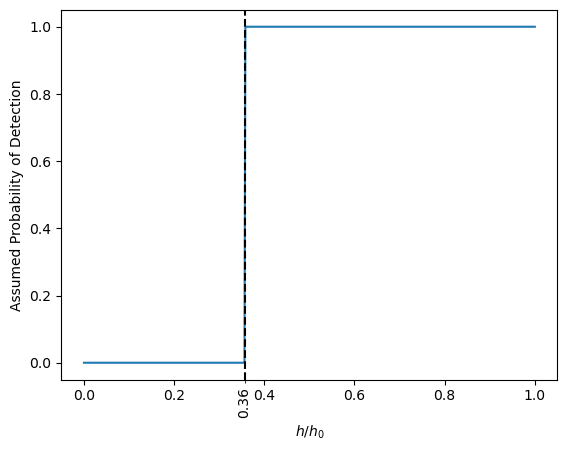

In [7]:
# Compute proportion of curve
fig,ax=plt.subplots(1,1)
plt.plot(theta_in_pi,[np.trapz([np.sin(theta_val) for theta_val in theta if theta_val <= theta_0],[theta_val for theta_val in theta if theta_val <= theta_0]) for theta_0 in theta])
plt.xlabel("Inclination ($\pi$ radians)")
plt.ylabel("Cumulative Probability Density")

# Compute 5% percentile of h
p_5 = np.arccos(0.05)
plt.axhline(0.95,color="black",linestyle="--")
plt.axvline(p_5/np.pi,color="black",linestyle="--")
plt.xlim(0,0.5)
plt.ylim(0,1.0)
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([0.95],["0.95"],minor=True)
ax.set_xticks([p_5/np.pi],["{:.2f}".format(p_5/np.pi)],minor=True,rotation=90)
#plt.savefig("Cumulative.png",bbox_inches="tight")
plt.show()

# Compute h factor at 5% percentile
p_5_power_template = ang_211_power(1e76,0.1,p_5,10)
p_5_h_factor_211 = ((p_5_power_template/auc)/max_v_auc_211)**0.5
print("5% Percentile h-factor is: {}".format(p_5_h_factor_211))

# Plot
fig,ax=plt.subplots(1,1)
plt.plot(theta_in_pi,h_function_211)
plt.xlabel("Inclination ($\pi$ radians)")
plt.ylabel("Correction factor for $h$ from $h_0$")
plt.axhline(p_5_h_factor_211,color="black",linestyle="--")
plt.axvline(p_5/np.pi,color="black",linestyle="--")
plt.xlim(0,0.5)
ax.set_yticks([p_5_h_factor_211],["{0:.2f}".format(p_5_h_factor_211)],minor=True)
ax.set_xticks([p_5/np.pi],["{:.2f}".format(p_5/np.pi)],minor=True,rotation=90)
#plt.savefig("Factor.png",bbox_inches="tight")
plt.show()

fig,ax = plt.subplots(1,1)
plt.plot(np.linspace(0,1,num=501),[0 if val < p_5_h_factor_211 else 1 for val in np.linspace(0,1,num=501)])
plt.xlabel("$h/h_0$")
plt.ylabel("Assumed Probability of Detection")
plt.axvline(p_5_h_factor_211,color="black",linestyle="--")
ax.set_xticks([p_5_h_factor_211],["{0:.2f}".format(p_5_h_factor_211)],minor=True,rotation=90)
#plt.savefig("Assumption.png",bbox_inches="tight")
plt.show()

### 322 Level
For the 322 level, we use SuperRad:

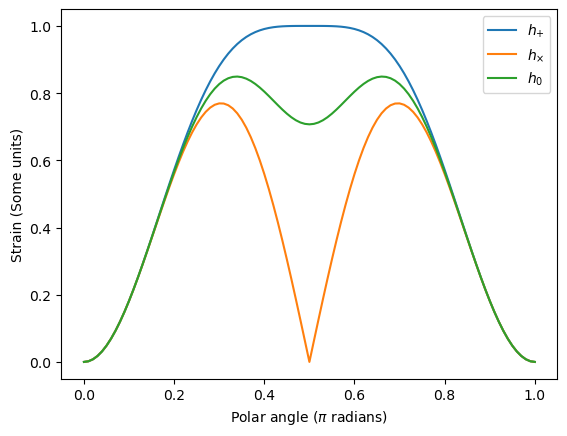

In [8]:
Mc = 1.0
Mbh = 14.8
abh = 0.5
_m = 2
mu_fac = 7.48548859e9
_mu = 1e-13*mu_fac # eV by factor
d_fac = 4.78691895e-20
_d = 2.25e-3*d_fac
_cloud_model = sr.rel_sca_cloud.RelScalar()

thetaObs_array = np.linspace(0,1*np.pi,num=101)
hp_array = np.zeros_like(thetaObs_array)
hx_array = np.zeros_like(thetaObs_array)

for i, thetaObs in enumerate(thetaObs_array):
    strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
    hl = strain_vec(_m, _mu*Mbh, abh)
    
    hp = 0.0
    hx = 0.0
    l = 2*_m 
    for hl0 in hl:
        Yp = har.sYlm(-2,l,2*_m,thetaObs)
        Ym = har.sYlm(-2,l,-2*_m,thetaObs)
        hp = hp + hl0*(Yp+(-1)**l*Ym)
        hx = hx + hl0*(Yp-(-1)**l*Ym)
        l = l + 1
    delta = np.angle(hx)-np.angle(hp)
    #Make delta in [-pi,pi)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi
    hp = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)
    hx = np.abs(hx)*(Mc/Mbh)/(_d/Mbh)
    
    hp_array[i] = hp
    hx_array[i] = hx

thetaObs = np.pi/2
strain_vec = np.vectorize(_cloud_model.strain_sph_harm, excluded=[0], signature='(),()->(n)')
hl = strain_vec(_m, _mu*Mbh, abh)

hp = 0.0
hx = 0.0
l = 2*_m 
for hl0 in hl:
    Yp = har.sYlm(-2,l,2*_m,thetaObs)
    Ym = har.sYlm(-2,l,-2*_m,thetaObs)
    hp = hp + hl0*(Yp+(-1)**l*Ym)
    hx = hx + hl0*(Yp-(-1)**l*Ym)
    l = l + 1
delta = np.angle(hx)-np.angle(hp)
#Make delta in [-pi,pi)
delta = (delta + np.pi) % (2 * np.pi) - np.pi
hp_norm = np.abs(hp)*(Mc/Mbh)/(_d/Mbh)

plt.plot(thetaObs_array/np.pi,hp_array/hp_norm,label="$h_{+}$")
plt.plot(thetaObs_array/np.pi,hx_array/hp_norm,label=r"$h_{\times}$")
plt.plot(thetaObs_array/np.pi,(((hp_array/hp_norm)**2+(hx_array/hp_norm)**2)*0.5)**0.5,label="$h_0$")
plt.legend()
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("Strain (Some units)")
plt.show()

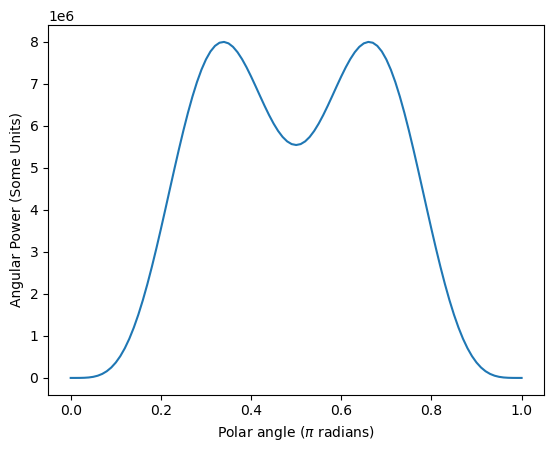

In [9]:
plt.plot(thetaObs_array/np.pi,(hp_array**2+hx_array**2),)#label="$h_0$")
#plt.legend()
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("Angular Power (Some Units)")
plt.show()

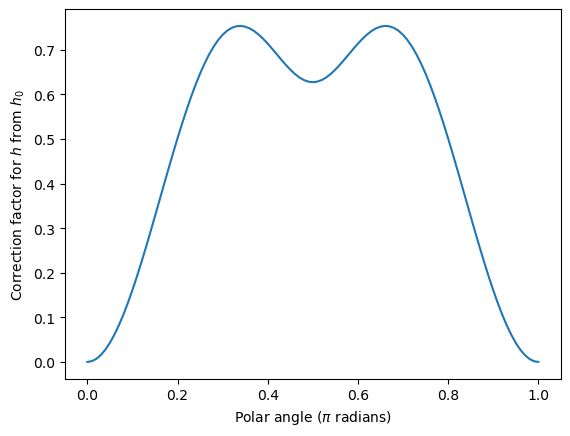

In [10]:
auc = np.trapz(np.sin(thetaObs_array)*(hp_array**2+hx_array**2))
# Compute h factor function
h_function_322 = (((hp_array**2+hx_array**2)/auc)/max_v_auc_211)**0.5

plt.plot(theta_in_pi,h_function_322)
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("Correction factor for $h$ from $h_0$")
plt.show()

## Transition Signals
We have that:

$$\frac{dP}{d\Omega}=\frac{G\hbar^2}{\pi c} \frac{N_{322}N_{211}\alpha^{14}}{r_g^4}\left(\frac{2^5}{3^6 5^8}(1-\cos^4\theta)+\frac{(27+28\cos(2\theta)+9\cos(4\theta))\sin^2\theta}{2^2 3^6 5^{10} 7^2}\right)$$

We also have that:

$$h_0 = \left(\frac{10G P_{\rm GW}}{c^3 r^2 \omega^2}\right)^{1/2} $$

So, in particular, $h_0\propto P^{1/2}$

In [11]:
def ang_transition_power(N_211,N_322,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = func.G*func.hbar**2/(np.pi*func.c)
    scale = N_322*N_211*alpha**14/r_g**4
    angular_dependence = 2**5/(3**6*5**8)*(1-np.cos(theta)**4)+((27+28*np.cos(2*theta)+9*np.cos(4*theta))*np.sin(theta)**2)/\
    (2**2*3**6*5**10*7**2)
    return const*scale*angular_dependence

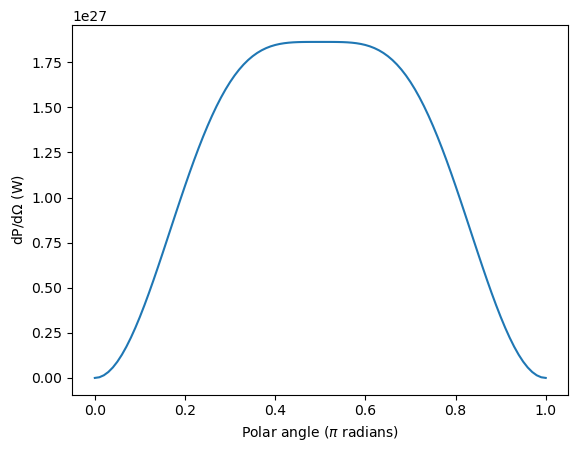

In [12]:
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi

# Plot power
ang_transition_template = ang_transition_power(1e76,1e76,0.1,theta,10)
plt.plot(theta_in_pi,ang_transition_template)
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("dP/d$\Omega$ (W)")
plt.show()

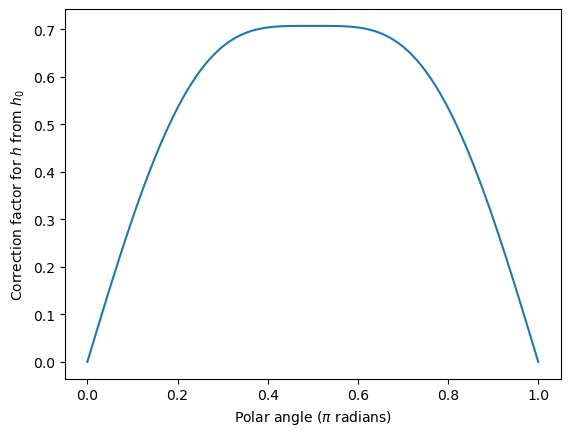

In [13]:
auc = np.trapz(np.sin(theta)*ang_transition_template)
# Compute h factor function
h_function_tr = ((ang_transition_template/auc)/max_v_auc_211)**0.5

plt.plot(theta_in_pi,h_function_tr)
plt.xlabel("Polar angle ($\pi$ radians)")
plt.ylabel("Correction factor for $h$ from $h_0$")
plt.show()

## Comparison

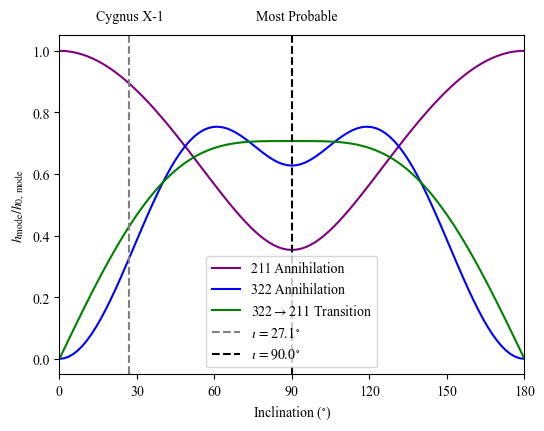

In [14]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.subplots(1,1,figsize=(6,4.4))
plt.plot(theta_in_pi*180,h_function_211,label="211 Annihilation",color="purple")
plt.plot(theta_in_pi*180,h_function_322,label="322 Annihilation",color="blue")
plt.plot(theta_in_pi*180,h_function_tr,label=r"$322\rightarrow 211$ Transition",color="green")
plt.axvline(27.1,label="$\iota\,=27.1^\circ$",linestyle="--",color="grey")
#plt.axvline(45*(2/360),label="45$^\circ$",linestyle="--",color="orange")
plt.axvline(90,label="$\iota\,=90.0^\circ$",linestyle="--",color="black")
plt.text(14,1.1,"Cygnus X-1")
#plt.text(0.2,1.1,"Optimal")
plt.text(76,1.1,"Most Probable")
plt.xlabel("Inclination ($^{\circ}$)")
plt.ylabel(r"$h_{\rm mode}/h_{\rm 0, \, mode}$")
plt.xticks(ticks=[0,30,60,90,120,150,180])
plt.legend()
plt.xlim(0,180)
#plt.savefig("CorrectionFactor.pdf",bbox_inches="tight")
plt.show()